In [60]:
import numpy as np
import pandas as pd

import re
import spacy
import string
from textblob import TextBlob
from textstat import textstat
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

from scipy.sparse import vstack
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import jaccard_score, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

import tensorflow_decision_forests as tfdf
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns


nlp = spacy.load('en_core_web_sm')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
pd.set_option('display.max_columns', None);

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df_train_prompt = pd.read_csv('commonlit-evaluate-student-summaries/prompts_train.csv')
df_train_summaries = pd.read_csv('commonlit-evaluate-student-summaries/summaries_train.csv')
# df_train = df_train_summaries.merge(df_train_prompt, on='prompt_id')

In [13]:
def relative_length(prompt_id, length):
    return length / len(df_train_prompt[df_train_prompt.prompt_id == prompt_id]['prompt'])


# Count the stop words in the text
def count_stopwords(text: str) -> int:
    stopword_list = set(stopwords.words('english'))
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stopword_list)
    return stopwords_count

# Count the punctuations in the text
# punctuation_set -> !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
def count_punctuation(text: str) -> int:
    punctuation_set = set(string.punctuation)
    punctuation_count = sum(1 for char in text if char in punctuation_set)
    return punctuation_count

# Count the digits in the text
def count_numbers(text: str) -> int:
    numbers = re.findall(r'\d+', text)
    numbers_count = len(numbers)
    return numbers_count

dict_tags = {'verb': ['VB', 'VBZ', 'VBP', 'VBD', 'VBN', 'VBG'],
             'noun': ['NN', 'NNS', 'NNP', 'NNPS'],
             'adj': ['JJ', 'JJR', 'JJS']}

# Clean and lemmatize the text
def lemmatize_text(text: str) -> list:
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = []
    for word in filtered_text:
        pos_tag = nltk.pos_tag([word])[0][1]
        if len(word) > 2:
            if pos_tag in dict_tags['verb']:
                lemmatized_text.append(lemmatizer.lemmatize(word, pos='v'))
            elif pos_tag in dict_tags['noun']:
                lemmatized_text.append(lemmatizer.lemmatize(word, pos='n'))
            elif pos_tag in dict_tags['adj']:
                lemmatized_text.append(lemmatizer.lemmatize(word, pos='a'))
            else:
                lemmatized_text.append(lemmatizer.lemmatize(word))
    return lemmatized_text

# This function applies lemmatize_text on text features
def lemmatize(dataframe : pd.DataFrame, features: str | list) -> pd.DataFrame:
    if isinstance(features, str):
        features = [features]
    for feature in features:
        dataframe[f'{feature}_lemmatized'] = dataframe[feature].apply(lemmatize_text)
    return dataframe

# Count unique words in the lemmatized text
def count_unique_words(words: list) -> int:
    unique_words_count = len(set(words))
    return unique_words_count


# Trains a vectorizer on a text
def vectorizer(df: pd.DataFrame, vectorizer=CountVectorizer(), n: int = 50) -> dict:
    vectorizer_dict = {}
    for _, row in df.iterrows():
        vectorizer_dict[row['prompt_id']] = {}
        for text in ['prompt', 'prompt_question']:
            lemmatized_text = ' '.join(row[f'{text}_lemmatized'])
            vectorizer.fit([lemmatized_text])
            word_counts = pd.DataFrame(vectorizer.transform([lemmatized_text]).toarray(), columns=vectorizer.get_feature_names_out())
            top_n_words = word_counts.sum().nlargest(n).index
            top_n_vectorizer = CountVectorizer(vocabulary=top_n_words)
            vectorizer_dict[row['prompt_id']][text] = top_n_vectorizer.fit([lemmatized_text])
    return vectorizer_dict


# Transform a list in a vector
def vectorize(lst: list, vectorizer: CountVectorizer) -> np.ndarray:
    sparse_matrix = vectorizer.transform([' '.join(lst)])
    vector = sparse_matrix.toarray()
    return vector

# Calculates Jaccard Similarity between two vectors
def jaccard_similarity(vec1: np.ndarray, vec2: np.ndarray) -> float:
    binary_vec1 = [1 if i else 0 for i in vec1[0]]
    binary_vec2 = [1 if i else 0 for i in vec2[0]]
    return jaccard_score(binary_vec1, binary_vec2)


# Extract NER
def ner(text: str) -> pd.DataFrame:
    vector = [(ent.text, ent.label_) for ent in nlp(text).ents]
    return vector

def jaccard_similarity_ner(list1: list[tuple[str]], list2: list[tuple[str]]) -> float:
    set1 = set(list1)
    set2 = set(list2)
    union_set = set1.union(set2)
    binary_vec1 = [1 if i in set1 else 0 for i in union_set]
    binary_vec2 = [1 if i in set2 else 0 for i in union_set]
    return jaccard_score(binary_vec1, binary_vec2)


def readability(text: str) -> pd.Series:
    flesch_reading_ease = textstat.flesch_reading_ease(text)
    gunning_fog = textstat.gunning_fog(text)
    ari = textstat.automated_readability_index(text)
    return pd.Series([flesch_reading_ease, gunning_fog, ari])


def cosine_similarity_sentiment(a: tuple[float], b: tuple[float]) -> float:
    if np.linalg.norm(a)*np.linalg.norm(b) == 0:
        return 0
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

def sentiment(text: str, prompt_id: str) -> float:
    text_blob = TextBlob(text)
    prompt_blob = df_train_prompt[df_train_prompt.prompt_id == prompt_id]['blob'].values[0]
    similarity = cosine_similarity_sentiment(prompt_blob.sentiment, text_blob.sentiment)
    return similarity

def tokenize(text: str):
    return ' '.join([tag for word, tag in nltk.pos_tag(nltk.word_tokenize(text))])

def tfidf_vectorizer(df_prompt: pd.DataFrame, df_summaries: pd.DataFrame) -> dict[TfidfVectorizer]:
    texts = df_prompt['tokens'].tolist() + df_summaries['tokens'].tolist()
    vectorizer_tfidf = TfidfVectorizer(ngram_range=(4,4))
    vectorizer_tfidf.fit(texts)
    return vectorizer_tfidf

def tfidf(text: str, vectorizer_tfidf: TfidfVectorizer) -> np.ndarray:
    vectors = vectorizer_tfidf.transform([text])
    return vectors


# def correlate_features(df: pd.DataFrame, columns: list = ['content', 'wording'], threshold: float = 0.1) -> dict:
#     correlations = {}
#     n_features = df['tfidf_vector'].iloc[0].shape[1]
#     for column in columns:
#         correlations[column] = [i for i in range(n_features) if abs(np.corrcoef(df[column], df['tfidf_vector'].apply(lambda x: x[0, i]))[0, 1]) > threshold]
#     return correlations

def tfidf_reductor(df: pd.DataFrame, target: str, n_components: int = 50) -> TruncatedSVD:
    tfidf_matrix = vstack(df['tfidf_vector'].values.tolist())
    svd = TruncatedSVD(n_components=n_components)
    svd.fit(tfidf_matrix, df[target])
    return svd


def vector_to_df(df: pd.DataFrame, reductor: TruncatedSVD) -> pd.DataFrame:
    reduced_vectors = reductor.transform(vstack(df['tfidf_vector'].values.tolist()))
    return pd.DataFrame(reduced_vectors)


In [5]:
df_train_prompt['prompt'] = df_train_prompt['prompt_title'] + '\n' + df_train_prompt['prompt_text']
df_train_prompt = lemmatize(df_train_prompt, ['prompt_question', 'prompt'])

vectorizer_dict = vectorizer(df_train_prompt)
df_train_prompt['vector_text'] = df_train_prompt.apply(lambda row: vectorize(row['prompt_lemmatized'], vectorizer_dict[row.prompt_id]['prompt']), axis=1)
df_train_prompt['vector_question'] = df_train_prompt.apply(lambda row: vectorize(row['prompt_question_lemmatized'], vectorizer_dict[row.prompt_id]['prompt_question']), axis=1)

df_train_prompt['ner_text'] = df_train_prompt.apply(lambda row: ner(row['prompt']), axis=1)
# df_train_prompt['ner_question'] = df_train_prompt.apply(lambda row: ner(row['prompt_question']), axis=1)

df_train_prompt['blob'] = df_train_prompt['prompt'].apply(TextBlob)

df_train_prompt['tokens'] = (df_train_prompt['prompt_question'] + '\n' + df_train_prompt['prompt']).apply(tokenize)
df_train_summaries['tokens'] = df_train_summaries['text'].apply(tokenize)
vectorizer_tfidf = tfidf_vectorizer(df_train_prompt, df_train_summaries)
df_train_summaries['tfidf_vector'] = df_train_summaries['tokens'].apply(lambda x: tfidf(x, vectorizer_tfidf))

In [19]:
content_reductor = tfidf_reductor(df_train_summaries, 'content')
wording_reductor = tfidf_reductor(df_train_summaries, 'wording')

In [11]:
# This function applies all the above preprocessing functions on a text feature
def feature_engineer(dataframe: pd.DataFrame, feature: str = 'text') -> pd.DataFrame:
    print('Calculating word count...                 ', end='')
    dataframe['word_cnt'] = dataframe[feature].apply(lambda x: len(x.split(' ')))
    print('   | Done')
    print('Calculating length...                     ', end='')
    dataframe['length'] = dataframe[feature].apply(len)
    print('   | Done')
    print('Calculating relative length...            ', end='')
    dataframe['relative_length'] = dataframe.apply(lambda row: relative_length(row.prompt_id, row.length), axis=1)
    print('   | Done')
    print('Calculating stopword relative count...    ', end='')
    dataframe['stopword_cnt'] = dataframe[feature].apply(count_stopwords) / dataframe['word_cnt']
    print('   | Done')
    print('Calculating punctuation relative count... ', end='')
    dataframe['punct_cnt'] = dataframe[feature].apply(count_punctuation) / dataframe['word_cnt']
    print('   | Done')
    print('Calculating number relative count...      ', end='')
    dataframe['number_cnt'] = dataframe[feature].apply(count_numbers) / dataframe['word_cnt']
    print('   | Done')
    print('Lemmatizing...                            ', end='')
    dataframe = lemmatize(dataframe, feature)
    print('   | Done')
    print('Calculating unique words count...         ', end='')
    dataframe['unique_words_cnt'] = dataframe[f'{feature}_lemmatized'].apply(count_unique_words)
    dataframe['relative_unique_words_cnt'] = dataframe['unique_words_cnt'] / len(dataframe[f'{feature}_lemmatized'])
    dataframe['unique_words_ratio'] = dataframe['unique_words_cnt'] / dataframe['word_cnt']
    print('   | Done')
    print('Vectorizing...                            ', end='')
    dataframe[f'{feature}_vector_text'] = dataframe.apply(lambda row: vectorize(row[f'{feature}_lemmatized'], vectorizer_dict[row.prompt_id]['prompt']), axis=1)
    dataframe[f'{feature}_vector_question'] = dataframe.apply(lambda row: vectorize(row[f'{feature}_lemmatized'], vectorizer_dict[row.prompt_id]['prompt_question']), axis=1)
    print('   | Done')
    print('Calculating Jaccard Similarity...         ', end='')
    dataframe['jaccard_similarity_prompt'] = dataframe.apply(lambda row: jaccard_similarity(row[f'{feature}_vector_text'], df_train_prompt.at[df_train_prompt[df_train_prompt.prompt_id == row.prompt_id].index[0], 'vector_text']), axis=1)
    dataframe['jaccard_similarity_question'] = dataframe.apply(lambda row: jaccard_similarity(row[f'{feature}_vector_question'], df_train_prompt.at[df_train_prompt[df_train_prompt.prompt_id == row.prompt_id].index[0], 'vector_question']), axis=1)
    print('   | Done')
    print('Calculating NER...                        ', end='')
    dataframe[f'{feature}_ner'] = dataframe[feature].apply(ner)
    print('   | Done')
    print('Calculating NER Jaccard Similarity...     ', end='')
    dataframe['ner_jaccard_similarity_prompt'] = dataframe.apply(lambda row: jaccard_similarity_ner(row[f'{feature}_ner'], df_train_prompt.at[df_train_prompt[df_train_prompt.prompt_id == row.prompt_id].index[0], 'ner_text']), axis=1)
    # dataframe['ner_jaccard_similarity_question' = dataframe.apply(lambda row: jaccard_similarity_ner(row[f'{feature}_ner'], df_train_prompt.at[df_train_prompt[df_train_prompt.prompt_id == row.prompt_id].index[0], 'ner_question']), axis=1)
    print('   | Done')
    print('Evaluating readability...                 ', end='')
    dataframe[['flesch_reading_ease', 'gunning_fog', 'ari']] = dataframe[feature].apply(readability)
    print('   | Done')
    print('Evaluating sentiment...                   ', end='')
    dataframe['sentiment_similarity'] = dataframe.apply(lambda row: sentiment(row[feature], row['prompt_id']), axis=1)
    print('   | Done')

In [12]:
df_train_summaries = feature_engineer(df_train_summaries)
df_train_summaries.head()

Calculating word count...                    | Done
Calculating length...                        | Done
Calculating relative length...               | Done
Calculating stopword relative count...       | Done
Calculating punctuation relative count...    | Done
Calculating number relative count...         | Done
Lemmatizing...                               | Done
Calculating unique words count...            | Done
Vectorizing...                               | Done
Calculating Jaccard Similarity...            | Done
Calculating NER...                           | Done
Calculating NER Jaccard Similarity...        | Done
Evaluating readability...                    | Done
Evaluating sentiment...                      | Done
Calculating TF-IDF...                     

AttributeError: 'DataFrame' object has no attribute 'lower'

In [14]:
df_train_summaries.describe()

,content,wording,word_cnt,length,relative_length,stopword_cnt,punct_cnt,number_cnt,unique_words_cnt,relative_unique_words_cnt,unique_words_ratio,jaccard_similarity_prompt,jaccard_similarity_question,ner_jaccard_similarity_prompt,flesch_reading_ease,gunning_fog,ari,sentiment_similarity
count,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000
mean,-0.014853,-0.063072,76.155618,418.776971,418.776971,0.478798,0.115388,0.004467,29.434473,0.004108,0.407165,0.189438,0.328307,0.043030,69.809719,11.173788,11.368555,0.899904
std,1.043569,1.036048,54.538587,307.833685,307.833685,0.061485,0.057931,0.011077,18.116236,0.002528,0.068952,0.111860,0.204555,0.069248,14.491586,4.821147,5.631759,0.202450
min,-1.729859,-1.962614,22.000000,114.000000,114.000000,0.090909,0.000000,0.000000,6.000000,0.000837,0.065657,0.000000,0.000000,0.000000,-62.510000,2.640000,-1.100000,0.000000
25%,-0.799545,-0.872720,40.000000,216.000000,216.000000,0.441315,0.075472,0.000000,17.000000,0.002373,0.360000,0.120000,0.166667,0.000000,62.010000,8.010000,7.800000,0.907296
50%,-0.093814,-0.081769,59.000000,320.000000,320.000000,0.480000,0.107527,0.000000,24.000000,0.003350,0.404255,0.160000,0.333333,0.000000,71.140000,10.300000,10.200000,0.970479
75%,0.499660,0.503833,93.000000,513.000000,513.000000,0.517241,0.147059,0.000000,36.000000,0.005024,0.450980,0.240000,0.444444,0.071429,79.300000,13.200000,13.500000,0.994210
max,3.900326,4.310693,651.000000,3940.000000,3940.000000,0.744681,0.903704,0.160000,207.000000,0.028890,0.692308,0.920000,0.888889,0.666667,108.030000,64.410000,77.500000,1.000000


In [15]:
df_train_summaries.columns

Index(['student_id', 'prompt_id', 'text', 'content', 'wording', 'tokens',
       'tfidf_vector', 'word_cnt', 'length', 'relative_length', 'stopword_cnt',
       'punct_cnt', 'number_cnt', 'text_lemmatized', 'unique_words_cnt',
       'relative_unique_words_cnt', 'unique_words_ratio', 'text_vector_text',
       'text_vector_question', 'jaccard_similarity_prompt',
       'jaccard_similarity_question', 'text_ner',
       'ner_jaccard_similarity_prompt', 'flesch_reading_ease', 'gunning_fog',
       'ari', 'sentiment_similarity'],
      dtype='object')

In [16]:
FEATURES = [
    #'stopword_cnt', 'punct_cnt', 'number_cnt',
    'relative_unique_words_cnt',
    'jaccard_similarity_prompt', 'jaccard_similarity_question',
    'ner_jaccard_similarity_prompt',
    #'ner_jaccard_similarity_question'
    'relative_length',
    'flesch_reading_ease', 'gunning_fog', 'ari',
    'sentiment_similarity',
    ]

TARGETS = ['content', 'wording']

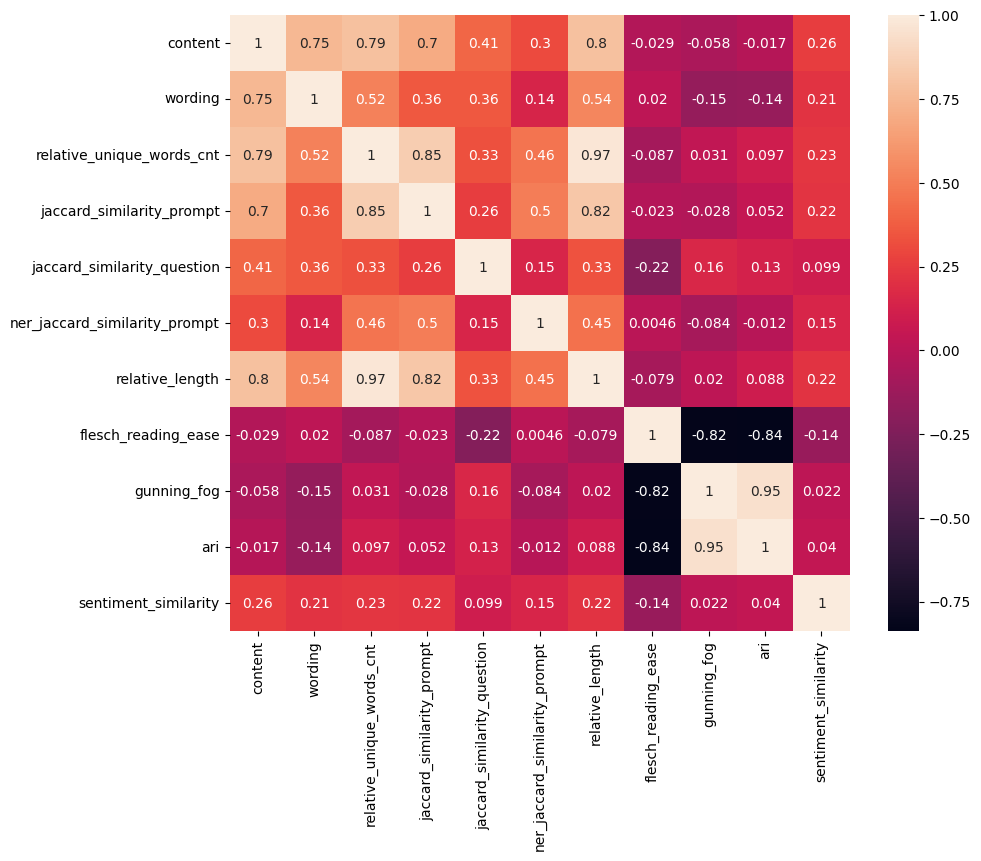

In [21]:
corr = df_train_summaries[TARGETS + FEATURES].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True);

In [26]:
df_train_summaries_content = pd.concat([df_train_summaries[['content'] + FEATURES], vector_to_df(df_train_summaries, content_reductor)], axis=1).rename({i : str(i) for i in range(50)}, axis=1)
df_train_summaries_content.head()

,content,relative_unique_words_cnt,jaccard_similarity_prompt,jaccard_similarity_question,ner_jaccard_similarity_prompt,relative_length,flesch_reading_ease,gunning_fog,ari,sentiment_similarity,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.205683,0.004187,0.12,0.222222,0.032258,346.0,64.41,9.40,8.3,0.885801,0.043984,-0.010734,0.023958,-0.011328,0.008828,-0.037270,0.049990,-0.010889,-0.007649,0.003014,0.024953,-0.006886,-0.007522,0.023033,-0.007179,-0.005376,0.007341,-0.004625,0.016082,-0.014735,-0.007797,-0.030535,0.001832,-0.011393,-0.007698,-0.010068,-0.040891,-0.000549,-0.007143,-0.013868,-0.039192,-0.014104,0.016737,-0.030751,0.011921,-0.000744,-0.033615,-0.016906,-0.003887,-0.008130,0.012976,0.003543,0.003247,-0.018131,0.008472,-0.010323,0.002622,0.007502,-0.002279,-0.025340
1,-0.548304,0.002094,0.08,0.166667,0.000000,244.0,87.39,10.40,9.0,0.693883,0.153397,0.046981,-0.034134,-0.000890,0.034349,-0.034312,-0.013258,-0.050090,-0.022671,-0.028504,0.052409,0.012334,0.024573,-0.003255,-0.020851,0.013237,0.015022,0.036039,-0.020693,-0.002113,0.008769,-0.030697,0.004950,-0.055388,0.018760,0.005648,0.016126,-0.010449,-0.002859,0.022688,0.032538,-0.017688,0.024985,-0.028759,-0.025006,0.014816,-0.053708,0.010024,-0.039413,-0.036459,0.000397,0.044516,-0.007927,-0.005422,-0.001254,-0.013524,0.008193,-0.040740,0.009090,-0.037067
2,3.128928,0.013817,0.50,0.266667,0.285714,1370.0,68.60,9.34,11.2,0.964619,0.146661,-0.063670,0.087841,-0.035803,0.034849,0.025453,-0.001001,-0.024585,0.020981,-0.051098,0.064271,-0.049821,0.027034,0.013614,0.016386,0.013968,0.001135,-0.019365,-0.018833,-0.054293,-0.013814,-0.043186,0.014473,-0.027391,-0.004069,-0.000171,-0.026646,-0.066908,-0.021176,-0.030740,-0.017922,0.045765,-0.002240,0.015673,-0.022552,0.022543,-0.004457,-0.023521,0.010155,-0.021998,0.022117,-0.053201,-0.020752,0.010479,-0.014404,-0.018237,0.006735,0.001722,-0.001033,-0.016436
3,-0.210614,0.001675,0.08,0.066667,0.000000,157.0,71.51,6.52,7.8,0.000000,0.054088,-0.039393,0.045903,-0.016782,0.000743,-0.002529,-0.000084,-0.000707,0.008930,0.015535,0.000106,0.014692,-0.009369,-0.022486,0.000152,0.027114,0.001380,-0.026366,-0.018864,-0.007664,-0.007393,-0.022778,-0.025094,-0.009424,-0.016810,0.000728,-0.003236,-0.002064,0.006871,-0.005549,-0.026340,-0.007853,-0.040276,0.002299,0.028130,0.000997,0.014416,-0.020003,0.043531,-0.014619,-0.006140,-0.018234,0.025735,0.011873,0.010513,-0.026982,0.024565,0.004624,-0.010660,-0.016641
4,3.272894,0.011863,0.34,0.555556,0.073171,1225.0,65.22,9.15,9.5,0.989275,0.135133,-0.068353,0.027566,0.015289,0.019586,-0.062205,0.058976,-0.002878,-0.022380,0.009333,-0.030470,-0.002756,0.002419,0.037437,-0.002660,0.012730,-0.004771,-0.002886,-0.027609,0.005460,0.038055,-0.040494,-0.025833,0.012994,0.016473,-0.014642,0.013981,-0.018233,0.010933,-0.021285,0.006058,0.048568,0.005638,-0.027787,-0.032483,0.023076,0.006452,-0.018928,-0.017744,0.008798,-0.021265,0.023288,0.009837,0.037929,-0.031770,-0.005442,-0.015171,-0.028111,-0.002262,0.027676


count    51.000000
mean      0.016582
std       0.156529
min      -0.129496
25%      -0.036035
50%      -0.003969
75%       0.024059
max       1.000000
Name: content, dtype: float64

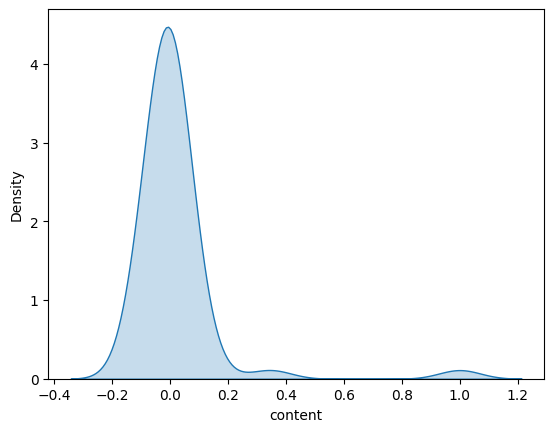

In [27]:
corr = df_train_summaries_content[['content'] + [str(i) for i in range(50)]].corr()
sns.kdeplot(corr['content'], fill=True)
corr['content'].describe()

In [28]:
df_train_summaries_wording = pd.concat([df_train_summaries[['wording'] + FEATURES], vector_to_df(df_train_summaries, wording_reductor)], axis=1).rename({i : str(i) for i in range(50)}, axis=1)
df_train_summaries_wording.head()

,wording,relative_unique_words_cnt,jaccard_similarity_prompt,jaccard_similarity_question,ner_jaccard_similarity_prompt,relative_length,flesch_reading_ease,gunning_fog,ari,sentiment_similarity,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.380538,0.004187,0.12,0.222222,0.032258,346.0,64.41,9.40,8.3,0.885801,0.043984,-0.010735,0.023957,-0.011326,0.008826,-0.037273,0.049959,-0.010888,-0.007625,0.002962,0.024908,-0.006798,-0.007524,0.022886,-0.008120,-0.005228,0.006658,0.005713,0.015104,-0.014905,-0.004722,-0.029400,0.004065,-0.011521,-0.007493,-0.008963,-0.037554,0.001166,-0.019782,0.022592,-0.035810,0.016499,-0.008392,-0.019662,0.014531,0.002242,-0.030352,0.008970,0.010192,-0.004931,-0.022672,-0.002385,0.023698,0.010005,0.001559,-0.006635,0.002813,0.001466,-0.001423,-0.028339
1,0.506755,0.002094,0.08,0.166667,0.000000,244.0,87.39,10.40,9.0,0.693883,0.153397,0.046981,-0.034136,-0.000888,0.034336,-0.034370,-0.013232,-0.050007,-0.022712,-0.028316,0.052092,0.012931,0.025090,-0.003071,-0.021598,0.014324,0.017170,-0.034832,-0.018610,-0.001743,0.010369,-0.034195,0.011040,-0.053645,0.026642,0.004289,0.017402,-0.012990,-0.007260,-0.049399,0.012716,0.025823,-0.016413,-0.031817,0.001332,0.031793,-0.032229,0.008654,-0.033715,-0.046833,-0.029623,0.020690,0.014016,-0.021272,0.047622,0.025126,0.011119,0.000596,-0.032068,-0.027132
2,4.231226,0.013817,0.50,0.266667,0.285714,1370.0,68.60,9.34,11.2,0.964619,0.146661,-0.063670,0.087840,-0.035805,0.034850,0.025442,-0.001022,-0.024565,0.020931,-0.051110,0.064317,-0.050059,0.027414,0.013018,0.016884,0.014343,0.000772,0.018338,-0.019431,-0.054607,-0.015442,-0.044624,0.013752,-0.027416,-0.005264,-0.006245,-0.019307,-0.063753,-0.037301,0.031556,-0.003363,-0.040443,-0.012123,0.008451,-0.021715,0.002277,-0.029554,-0.029865,0.017567,-0.027550,0.043582,-0.008342,0.001424,-0.003997,-0.033449,-0.012739,-0.016177,-0.004541,0.001272,-0.025220
3,-0.471415,0.001675,0.08,0.066667,0.000000,157.0,71.51,6.52,7.8,0.000000,0.054088,-0.039393,0.045902,-0.016782,0.000745,-0.002524,-0.000078,-0.000711,0.008904,0.015471,0.000149,0.014727,-0.008946,-0.022831,0.000034,0.027030,0.001546,0.026373,-0.019980,-0.008100,-0.006328,-0.022335,-0.023633,-0.008930,-0.014638,0.003842,-0.000623,-0.000023,-0.001581,0.019064,-0.018611,-0.018646,0.032130,0.006104,0.028809,-0.001383,0.004009,0.010299,0.042684,0.004192,0.005203,-0.026993,0.004409,0.013719,0.023456,-0.012960,-0.017714,-0.002750,-0.013461,-0.006499
4,3.219757,0.011863,0.34,0.555556,0.073171,1225.0,65.22,9.15,9.5,0.989275,0.135133,-0.068353,0.027565,0.015289,0.019581,-0.062226,0.058990,-0.002830,-0.022380,0.009505,-0.030492,-0.002666,0.002720,0.037712,-0.001877,0.013201,-0.003774,0.002234,-0.027228,0.004436,0.037710,-0.041032,-0.025791,0.014932,0.018136,-0.014995,0.018491,-0.019352,-0.004820,0.012322,0.017418,-0.037721,-0.024777,-0.027444,-0.031408,0.028425,0.017696,-0.011071,-0.007686,0.011099,-0.020106,-0.008610,-0.019463,0.041891,-0.027324,0.016396,-0.008979,-0.012201,-0.020096,0.019265


count    51.000000
mean     -0.000016
std       0.154614
min      -0.221755
25%      -0.037808
50%      -0.011780
75%       0.015092
max       1.000000
Name: wording, dtype: float64

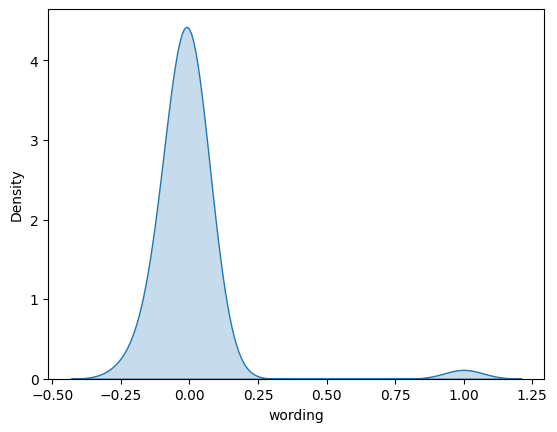

In [29]:
corr = df_train_summaries_wording[['wording'] + [str(i) for i in range(50)]].corr()
sns.kdeplot(corr['wording'], fill=True)
corr['wording'].describe()

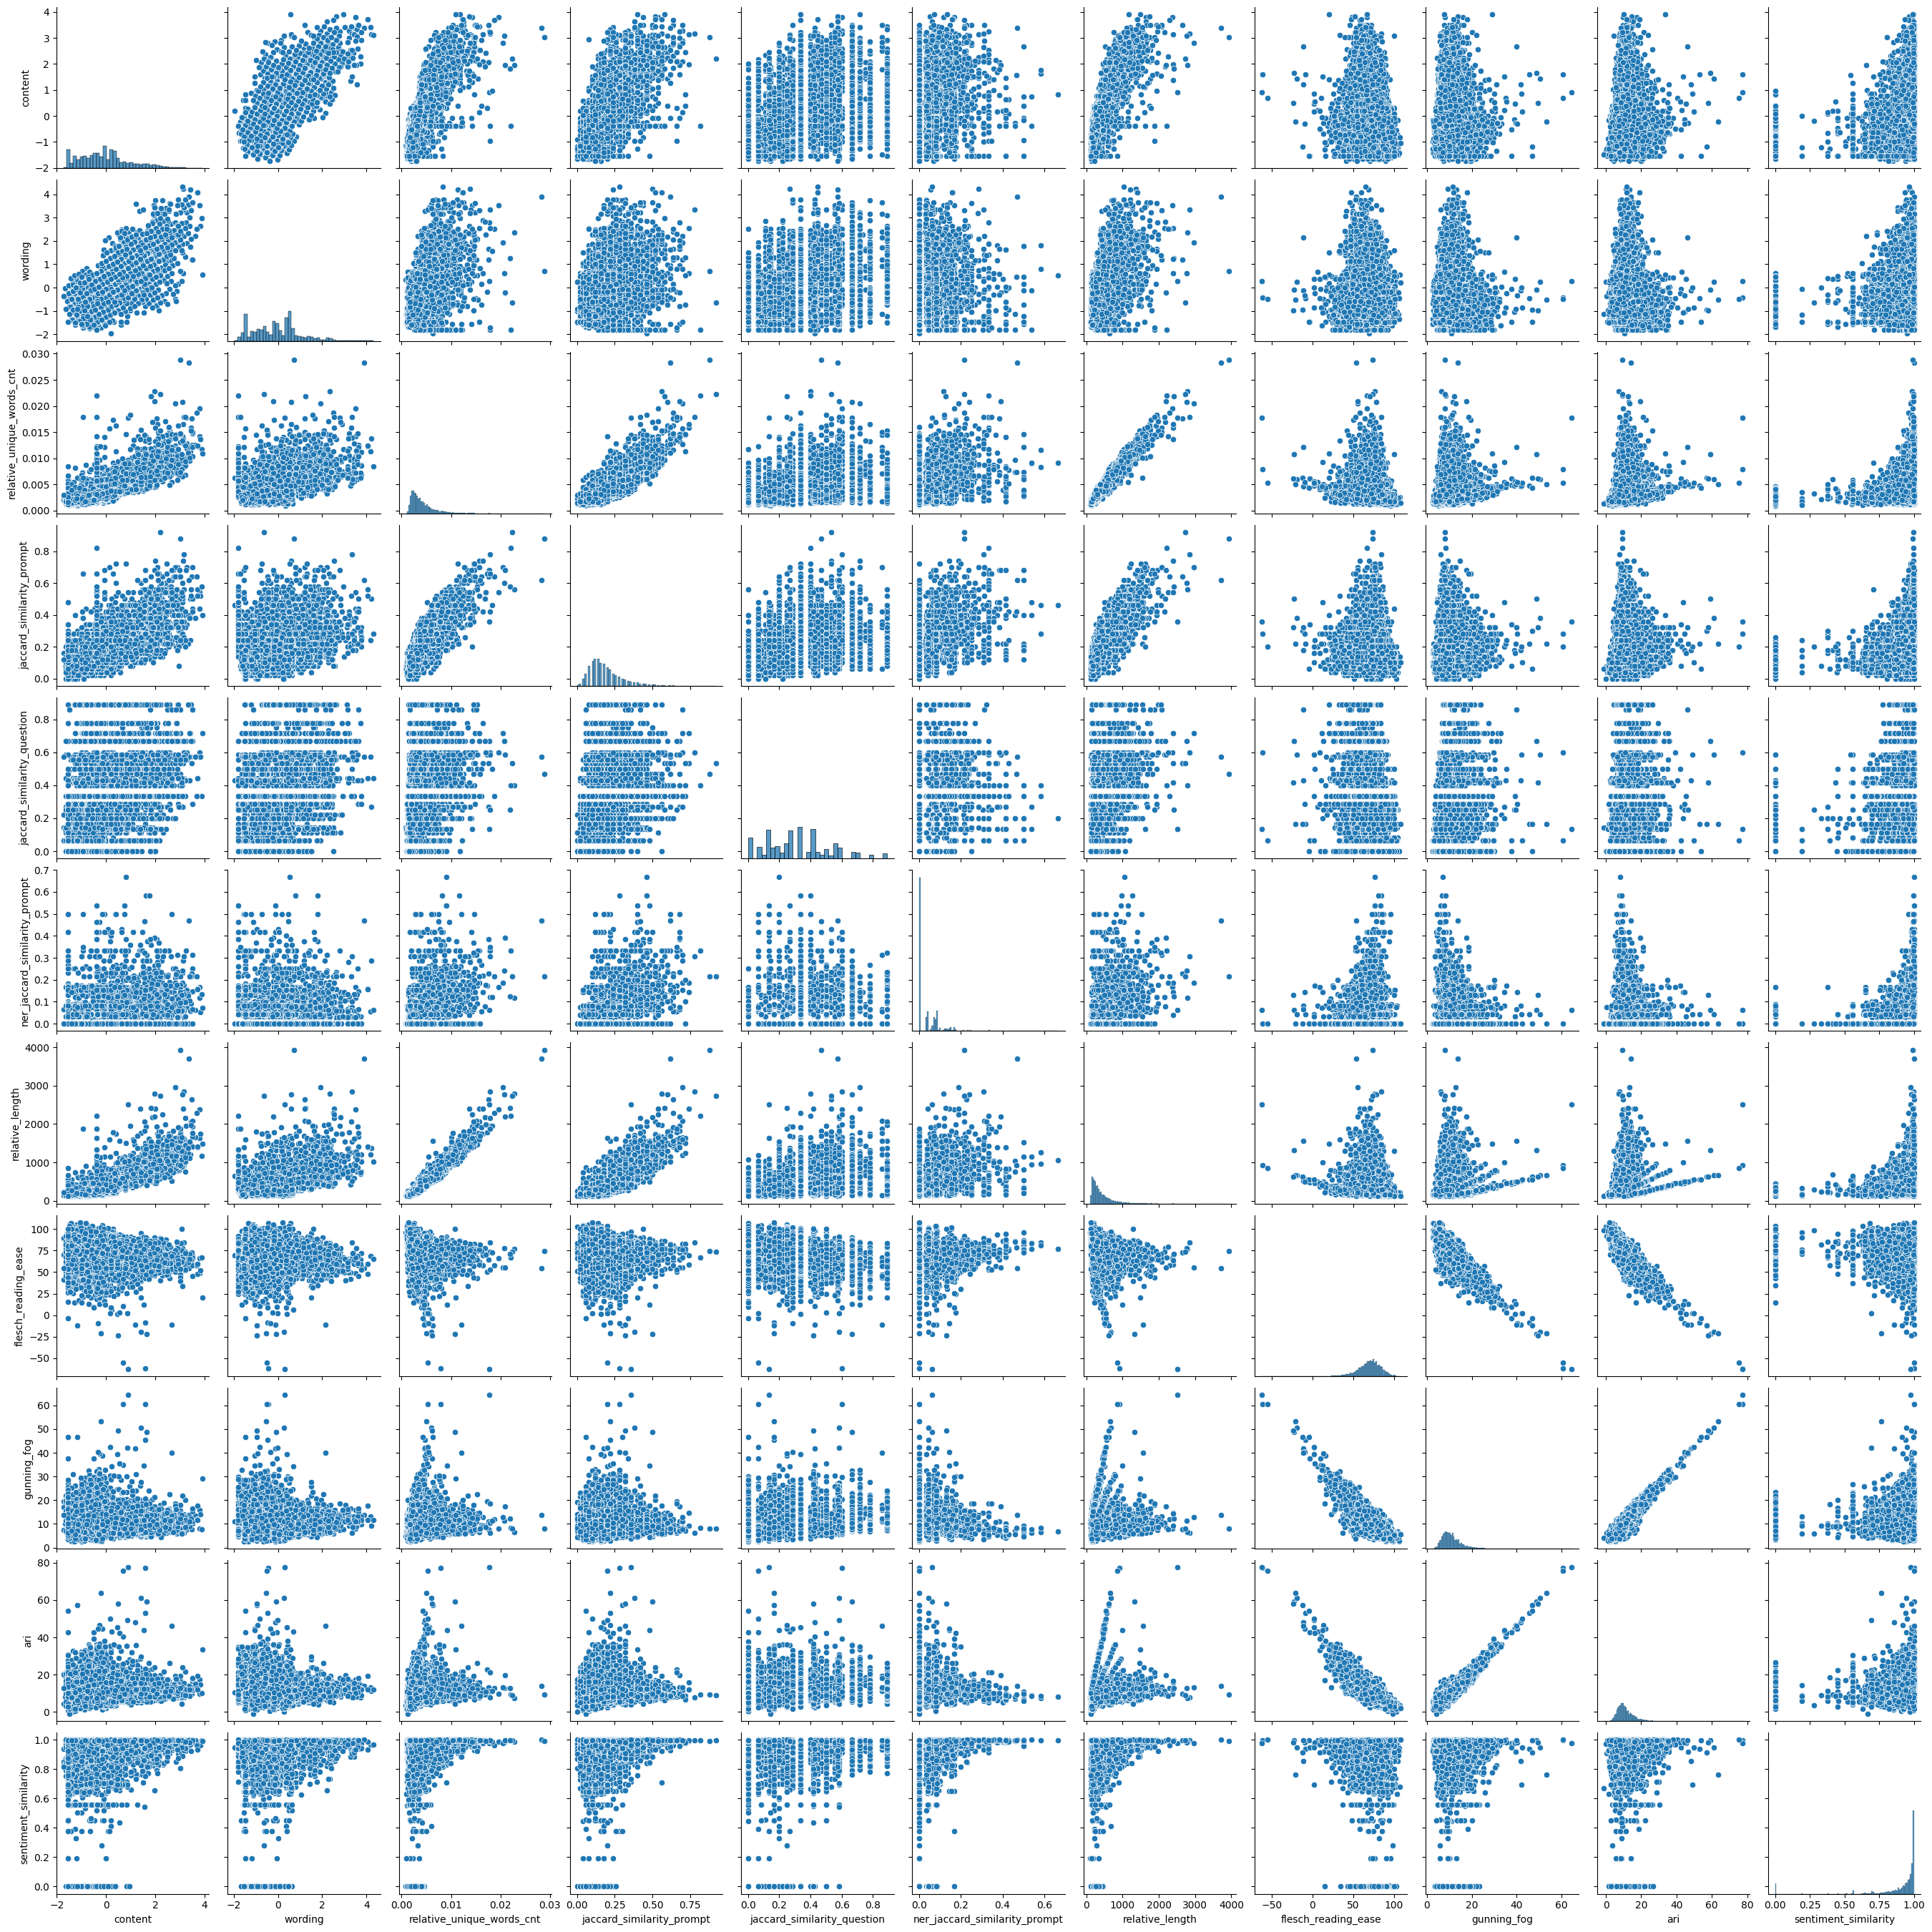

In [53]:
sns.pairplot(df_train_summaries[TARGETS + FEATURES])

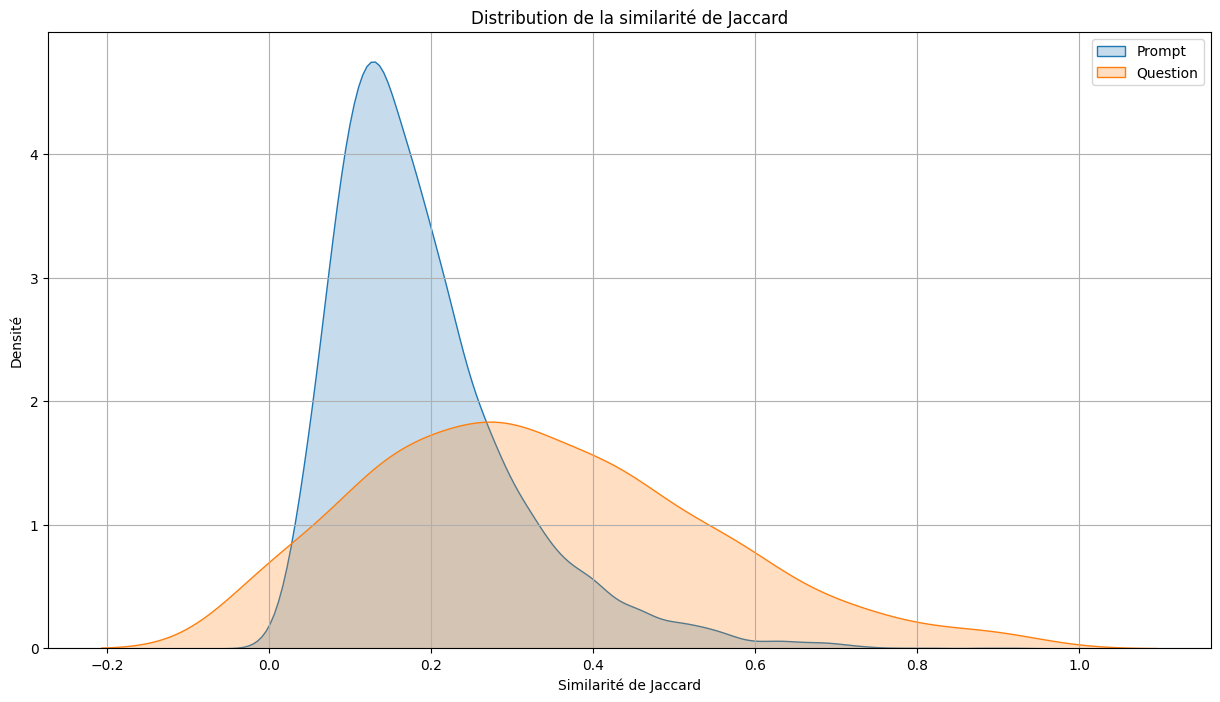

In [100]:
plt.figure(figsize=(15,8))
sns.kdeplot(df_train_summaries['jaccard_similarity_prompt'], fill=True, label="Prompt")
sns.kdeplot(df_train_summaries['jaccard_similarity_question'], fill=True, label="Question", bw_adjust=2)
plt.title("Distribution de la similarité de Jaccard")
plt.xlabel('Similarité de Jaccard')
plt.ylabel('Densité')
plt.legend()
plt.grid()

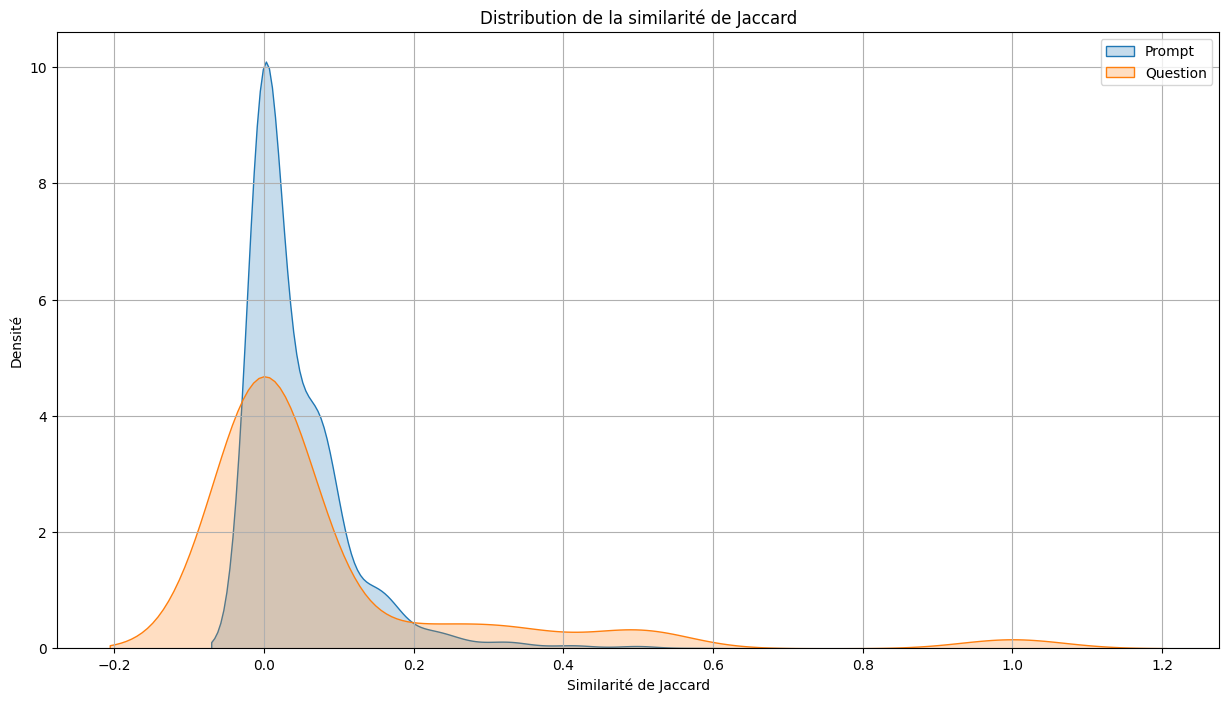

In [15]:
plt.figure(figsize=(15,8))
sns.kdeplot(df_train_summaries['ner_jaccard_similarity_prompt'], fill=True, label="Prompt", bw_adjust=2)
sns.kdeplot(df_train_summaries['ner_jaccard_similarity_question'], fill=True, label="Question", bw_adjust=2)
plt.title("Distribution de la similarité de Jaccard")
plt.xlabel('Similarité de Jaccard')
plt.ylabel('Densité')
plt.legend()
plt.grid()

In [66]:
def calculate_r_squared(mse, target):
    target_mean = np.mean(target)
    total_sum_of_squares = np.sum((target - target_mean) ** 2)
    r_squared = 1 - (mse*len(target) / total_sum_of_squares)
    return r_squared

In [48]:
def scale_features(df_train: pd.DataFrame, features: list[str], scaler=MinMaxScaler(), df_test=None):
    scaler.fit(df_train[features])
    df_to_fit = df_test.reset_index(drop=True) if isinstance(df_test, pd.DataFrame) else df_train.reset_index(drop=True)
    df_to_fit[features] = pd.DataFrame(scaler.transform(df_to_fit[features])).rename(columns={i : column for i, column in enumerate(df_to_fit[features].columns)})
    return df_to_fit


train_content, test_content = train_test_split(df_train_summaries_content, test_size=0.2, random_state=42)
train_wording, test_wording = train_test_split(df_train_summaries_wording, test_size=0.2, random_state=42)

train_content_scaled = scale_features(train_content, FEATURES)
test_content_scaled = scale_features(train_content, FEATURES, df_test=test_content)

train_wording_scaled = scale_features(train_wording, FEATURES)
test_wording_scaled = scale_features(train_wording, FEATURES, df_test=test_wording)

In [64]:
param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1]
}

xgb = XGBRegressor()
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(train_content_scaled.drop(columns='content'), train_content_scaled['content'])
best_params_content = grid_search.best_params_
print(best_params_content)
# {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 700, 'subsample': 0.5}

{'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 700, 'subsample': 0.5}


In [65]:
model_content_xgb = XGBRegressor(objective='reg:squarederror', colsample_bytree=1, learning_rate=0.01, max_depth=7, n_estimators=700, subsample=0.5)
r2_scores = cross_val_score(model_content_xgb, train_content_scaled.drop(columns='content'), train_content_scaled['content'], cv=5)

print("Cross-validation R² scores: ", r2_scores)
print("Average cross-validation R² score: ", r2_scores.mean())

Cross-validation R² scores:  [0.81643911 0.82236013 0.82301203 0.80454041 0.81108784]
Average cross-validation R² score:  0.81548790409439


In [69]:
model_content_xgb = XGBRegressor(objective='reg:squarederror', colsample_bytree=1, learning_rate=0.01, max_depth=7, n_estimators=700, subsample=0.5)
model_content_xgb.fit(train_content_scaled.drop(columns='content'), train_content_scaled['content'])
predictions_content = model_content_xgb.predict(test_content_scaled.drop(columns='content'))
mse_valid_content = mean_squared_error(test_content_scaled['content'], predictions_content)
r2_valid_content = calculate_r_squared(mse_valid_content, test_content_scaled['content'])

print(f"""
Validation MSE: {mse_valid_content}
Validation RMSE: {mse_valid_content**0.5}
Validation R²: {r2_valid_content}
""")


Validation MSE: 0.18505079317598452
Validation RMSE: 0.4301753051675381
Validation R²: 0.8319586925143194



In [ ]:
param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1]
}

xgb = XGBRegressor()
grid_search_wording = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_wording.fit(train_wording_scaled.drop(columns='wording'), train_wording_scaled['wording'])
best_params_wording = grid_search_wording.best_params_
print(best_params_wording)

In [71]:
model_wording_xgb = XGBRegressor(objective='reg:squarederror', colsample_bytree=1, learning_rate=0.01, max_depth=7, n_estimators=700, subsample=0.5)
r2_scores = cross_val_score(model_wording_xgb, train_wording_scaled.drop(columns='wording'), train_wording_scaled['wording'], cv=5)

print("Cross-validation R² scores: ", r2_scores)
print("Average cross-validation R² score: ", r2_scores.mean())

Cross-validation R² scores:  [0.67664211 0.65868137 0.66292306 0.64146993 0.66030796]
Average cross-validation R² score:  0.6600048848062791


In [70]:
model_wording_xgb = XGBRegressor(objective='reg:squarederror', colsample_bytree=1, learning_rate=0.01, max_depth=7, n_estimators=700, subsample=0.5)
model_wording_xgb.fit(train_wording_scaled.drop(columns='wording'), train_wording_scaled['wording'])
predictions_wording = model_wording_xgb.predict(test_wording_scaled.drop(columns='wording'))
mse_valid_wording = mean_squared_error(test_wording_scaled['wording'], predictions_wording)
r2_valid_wording = calculate_r_squared(mse_valid_wording, test_wording_scaled['wording'])

print(f"""
Validation MSE: {mse_valid_wording}
Validation RMSE: {mse_valid_wording**0.5}
Validation R²: {r2_valid_wording}
""")


Validation MSE: 0.3355205009585027
Validation RMSE: 0.5792413149616511
Validation R²: 0.6726457414278727



In [51]:
model_wording_xgb = XGBRegressor(objective='reg:squarederror', colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.7)
model_wording_xgb.fit(train_wording_scaled.drop(columns='wording'), train_wording_scaled['wording'])

predictions_wording = model_wording_xgb.predict(test_wording_scaled.drop(columns='wording'))

mse_train_wording = mean_squared_error(train_wording_scaled['wording'], model_wording_xgb.predict(train_wording_scaled.drop(columns='wording')))
r2_train_wording = calculate_r_squared(mse_train_wording, train_wording_scaled['wording'])

mse_valid_wording = mean_squared_error(test_wording_scaled['wording'], predictions_wording)
r2_valid_wording = calculate_r_squared(mse_valid_wording, test_wording_scaled['wording'])

print(f"""
  - Training MSE: {mse_train_wording}
  - Training RMSE: {mse_train_wording**0.5}
  - Training R²: {r2_train_wording}

  - Validation MSE: {mse_valid_wording}
  - Validation RMSE: {mse_valid_wording**0.5}
  - Validation R²: {r2_valid_wording}
""")


  - Training MSE: 0.12797864071310683
  - Training RMSE: 0.35774102464367546
  - Training R²: 0.882074214456733

  - Validation MSE: 0.340157514121033
  - Validation RMSE: 0.5832302410892571
  - Validation R²: 0.6681215886518936



In [52]:
content_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_content_scaled, label='content', task = tfdf.keras.Task.REGRESSION)
wording_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_wording_scaled, label='wording', task = tfdf.keras.Task.REGRESSION)

model_content = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
model_content.compile(metrics=["mse"])

model_wording = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
model_wording.compile(metrics=["mse"])


model_content.fit(x=content_train_ds)

model_wording.fit(x=wording_train_ds)

Use /tmp/tmpif45cnl6 as temporary training directory
Use /tmp/tmpozij2ex1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.606795. Found 5732 examples.
Training model...


[INFO 24-02-12 19:49:11.8557 CET kernel.cc:1233] Loading model from path /tmp/tmpif45cnl6/model/ with prefix f12ae9871bce4062


Model trained in 0:00:02.647140
Compiling model...


[INFO 24-02-12 19:49:12.3055 CET decision_forest.cc:660] Model loaded with 300 root(s), 482184 node(s), and 59 input feature(s).
[INFO 24-02-12 19:49:12.3056 CET abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-02-12 19:49:12.3056 CET kernel.cc:1061] Use fast generic engine


Model compiled.
Reading training dataset...
Training dataset read in 0:00:00.636663. Found 5732 examples.
Training model...


[INFO 24-02-12 19:49:15.6767 CET kernel.cc:1233] Loading model from path /tmp/tmpozij2ex1/model/ with prefix fe6649bec93742bc


Model trained in 0:00:02.672585
Compiling model...


[INFO 24-02-12 19:49:16.0492 CET decision_forest.cc:660] Model loaded with 300 root(s), 438198 node(s), and 59 input feature(s).
[INFO 24-02-12 19:49:16.0492 CET kernel.cc:1061] Use fast generic engine


Model compiled.


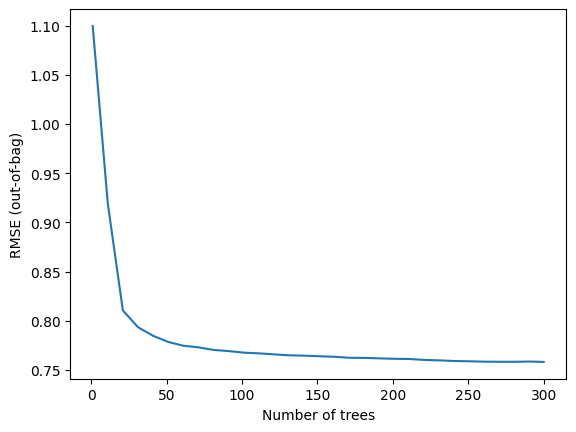

In [39]:
# Plot log data for model_content
logs = model_content.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

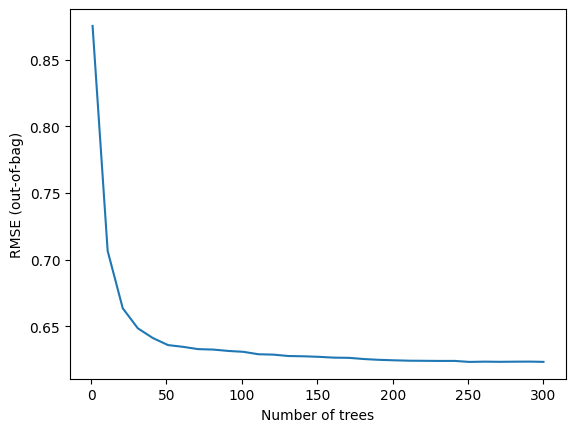

In [53]:
# Plot log data for model_wording
logs = model_wording.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [54]:
# General stats for model_content
inspector_content = model_content.make_inspector()
inspector_content.evaluation()

Evaluation(num_examples=5732, accuracy=None, loss=None, rmse=0.4541930336400879, ndcg=None, aucs=None, auuc=None, qini=None)

In [55]:
# General stats for model_wording
inspector_wording = model_wording.make_inspector()
inspector_wording.evaluation()

Evaluation(num_examples=5732, accuracy=None, loss=None, rmse=0.623374553265875, ndcg=None, aucs=None, auuc=None, qini=None)

In [56]:
# Create validation dataset for model_content
valid_ds_content = tfdf.keras.pd_dataframe_to_tf_dataset(test_content_scaled, label="content", task = tfdf.keras.Task.REGRESSION)

# Create validation dataset for model_wording
valid_ds_wording = tfdf.keras.pd_dataframe_to_tf_dataset(test_wording, label="wording", task = tfdf.keras.Task.REGRESSION)

# Run evaluation for model_content
evaluation_content = model_content.evaluate(x=valid_ds_content,return_dict=True)
for name, value in evaluation_content.items():
  print(f"{name}: {value:.4f}")

# Run evaluation for model_wording
evaluation_wording = model_wording.evaluate(x=valid_ds_wording,return_dict=True)
for name, value in evaluation_wording.items():
  print(f"{name}: {value:.4f}")

2/2 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - mse: 0.1992
loss: 0.0000
mse: 0.1992
2/2 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - mse: 0.8778
loss: 0.0000
mse: 0.8778


In [57]:
r2_content = calculate_r_squared(evaluation_content['mse'], df_train_summaries['content'])
r2_wording = calculate_r_squared(evaluation_wording['mse'], df_train_summaries['wording'])
print(r2_content, r2_wording)

0.81703779260555 0.18208122835341845


In [58]:
inspector_content.variable_importances()["NUM_AS_ROOT"]

[("relative_length" (1; #57), 118.0),
 ("relative_unique_words_cnt" (1; #58), 65.0),
 ("jaccard_similarity_prompt" (1; #54), 42.0),
 ("jaccard_similarity_question" (1; #55), 26.0),
 ("ner_jaccard_similarity_prompt" (1; #56), 17.0),
 ("0" (1; #0), 11.0),
 ("1" (1; #1), 7.0),
 ("sentiment_similarity" (1; #59), 7.0),
 ("2" (1; #12), 3.0),
 ("3" (1; #23), 2.0),
 ("11" (1; #3), 1.0),
 ("gunning_fog" (1; #53), 1.0)]

In [59]:
inspector_wording.variable_importances()["NUM_AS_ROOT"]

[("relative_length" (1; #57), 118.0),
 ("relative_unique_words_cnt" (1; #58), 65.0),
 ("jaccard_similarity_prompt" (1; #54), 38.0),
 ("jaccard_similarity_question" (1; #55), 31.0),
 ("ner_jaccard_similarity_prompt" (1; #56), 15.0),
 ("gunning_fog" (1; #53), 13.0),
 ("5" (1; #45), 8.0),
 ("ari" (1; #51), 7.0),
 ("sentiment_similarity" (1; #59), 3.0),
 ("18" (1; #10), 1.0),
 ("2" (1; #12), 1.0)]

In [54]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(df_train_summaries[TARGETS + FEATURES])

mms = MinMaxScaler()
mms.fit(train_ds_pd[FEATURES])
train_ds_pd_scaled = pd.concat([train_ds_pd[TARGETS].reset_index(drop=True), pd.DataFrame(mms.transform(train_ds_pd[FEATURES])).rename(columns={i : column for i, column in enumerate(train_ds_pd[FEATURES].columns)})], axis=1)
valid_ds_pd_scaled = pd.concat([valid_ds_pd[TARGETS].reset_index(drop=True), pd.DataFrame(mms.transform(valid_ds_pd[FEATURES])).rename(columns={i : column for i, column in enumerate(valid_ds_pd[FEATURES].columns)})], axis=1)

train_ds_pd_scaled_content = train_ds_pd_scaled.drop(columns='wording')
train_ds_pd_scaled_wording = train_ds_pd_scaled.drop(columns='content')

# Convert dataframes to corresponding datasets
content_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd_scaled_content, label='content', task = tfdf.keras.Task.REGRESSION)
wording_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd_scaled_wording, label='wording', task = tfdf.keras.Task.REGRESSION)

2024-02-12 10:44:14.858304: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-12 10:44:14.864873: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-12 10:44:14.864924: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-12 10:44:14.869383: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-12 10:44:14.869441: I external/local_xla/xla/stream_executor

<Axes: ylabel='Density'>

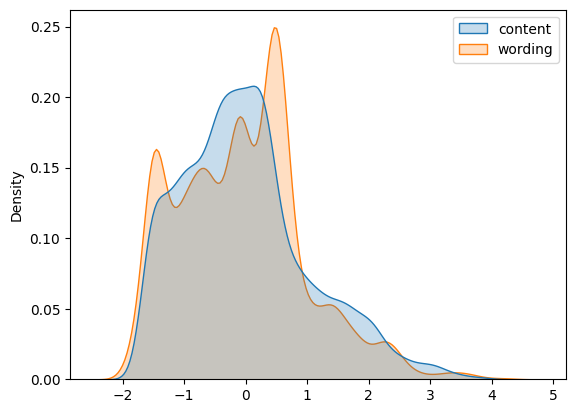

In [81]:
sns.kdeplot(df_train_summaries[TARGETS], fill=True)

<Axes: ylabel='Density'>

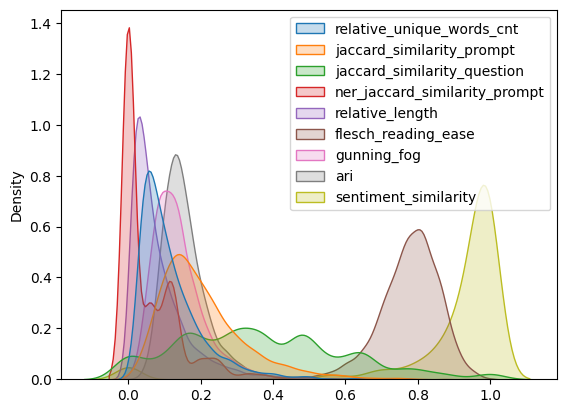

In [55]:
sns.kdeplot(train_ds_pd_scaled[FEATURES], fill=True)

In [56]:
# Create RandomForestModel for label content
model_content = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
model_content.compile(metrics=["mse"])

# Create RandomForestModel for label wording
model_wording = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
model_wording.compile(metrics=["mse"])

Use /tmp/tmp8rk7a7fe as temporary training directory


Use /tmp/tmpf1sryb7h as temporary training directory


In [57]:
# Training RandomForestModel for label content
model_content.fit(x=content_train_ds)

# Training RandomForestModel for label wording
model_wording.fit(x=wording_train_ds)

Reading training dataset...
Training dataset read in 0:00:03.966840. Found 5757 examples.
Training model...


[INFO 24-02-12 10:45:06.5837 CET kernel.cc:1233] Loading model from path /tmp/tmp8rk7a7fe/model/ with prefix 66bea98215b048be
[INFO 24-02-12 10:45:07.1581 CET decision_forest.cc:660] Model loaded with 300 root(s), 499462 node(s), and 9 input feature(s).
[INFO 24-02-12 10:45:07.1582 CET abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-02-12 10:45:07.1583 CET kernel.cc:1061] Use fast generic engine


Model trained in 0:00:01.854577
Compiling model...
Model compiled.
Reading training dataset...
Training dataset read in 0:00:00.165774. Found 5757 examples.
Training model...


[INFO 24-02-12 10:45:10.2487 CET kernel.cc:1233] Loading model from path /tmp/tmpf1sryb7h/model/ with prefix 3fcbbf78a0a64f12


Model trained in 0:00:01.192635
Compiling model...


[INFO 24-02-12 10:45:10.6214 CET decision_forest.cc:660] Model loaded with 300 root(s), 465984 node(s), and 9 input feature(s).
[INFO 24-02-12 10:45:10.6215 CET kernel.cc:1061] Use fast generic engine


Model compiled.


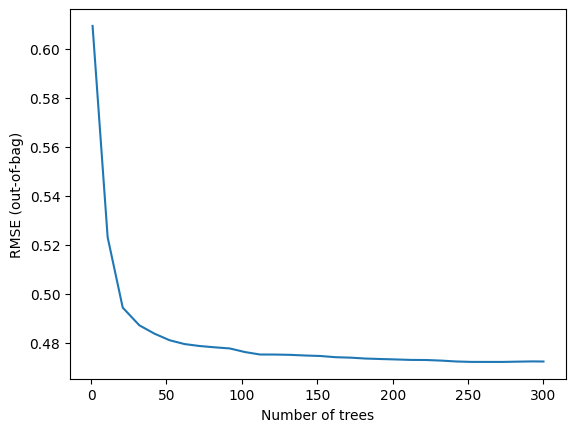

In [58]:
# Plot log data for model_content
logs = model_content.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

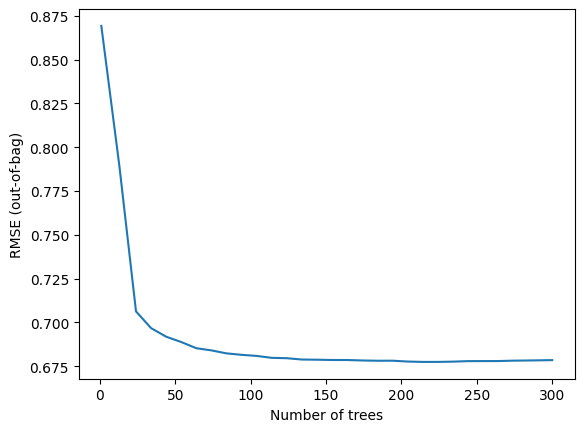

In [59]:
# Plot log data for model_wording
logs = model_wording.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [60]:
# General stats for model_content
inspector_content = model_content.make_inspector()
inspector_content.evaluation()

Evaluation(num_examples=5757, accuracy=None, loss=None, rmse=0.47239739764726324, ndcg=None, aucs=None, auuc=None, qini=None)

In [61]:
# General stats for model_wording
inspector_wording = model_wording.make_inspector()
inspector_wording.evaluation()

Evaluation(num_examples=5757, accuracy=None, loss=None, rmse=0.6785256143368642, ndcg=None, aucs=None, auuc=None, qini=None)

In [62]:
# Create validation dataset for model_content
valid_ds_content = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd_scaled, label="content", task = tfdf.keras.Task.REGRESSION)

# Create validation dataset for model_wording
valid_ds_wording = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd_scaled, label="wording", task = tfdf.keras.Task.REGRESSION)

# Run evaluation for model_content
evaluation_content = model_content.evaluate(x=valid_ds_content,return_dict=True)
for name, value in evaluation_content.items():
  print(f"{name}: {value:.4f}")

# Run evaluation for model_wording
evaluation_wording = model_wording.evaluate(x=valid_ds_wording,return_dict=True)
for name, value in evaluation_wording.items():
  print(f"{name}: {value:.4f}")

2/2 [==============================] - 1s 21ms/step - loss: 0.0000e+00 - mse: 0.2404
loss: 0.0000
mse: 0.2404
2/2 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - mse: 0.4868
loss: 0.0000
mse: 0.4868


In [74]:
def calculate_r_squared(mse, target):
    target_mean = np.mean(target)
    total_sum_of_squares = np.sum((target - target_mean) ** 2)
    r_squared = 1 - (mse*len(target) / total_sum_of_squares)
    return r_squared

r2_content = calculate_r_squared(evaluation_content['mse'], df_train_summaries['content'])
r2_wording = calculate_r_squared(evaluation_wording['mse'], df_train_summaries['wording'])
print(r2_content, r2_wording)

0.7792467306565537 0.5464347618435313


In [64]:
inspector_content.variable_importances()["NUM_AS_ROOT"]

[("relative_length" (1; #7), 129.0),
 ("relative_unique_words_cnt" (1; #8), 98.0),
 ("jaccard_similarity_prompt" (1; #4), 44.0),
 ("jaccard_similarity_question" (1; #5), 16.0),
 ("ner_jaccard_similarity_prompt" (1; #6), 9.0),
 ("sentiment_similarity" (1; #9), 4.0)]

In [65]:
inspector_wording.variable_importances()["NUM_AS_ROOT"]

[("relative_length" (1; #7), 129.0),
 ("relative_unique_words_cnt" (1; #8), 98.0),
 ("jaccard_similarity_prompt" (1; #4), 41.0),
 ("jaccard_similarity_question" (1; #5), 19.0),
 ("gunning_fog" (1; #3), 7.0),
 ("ner_jaccard_similarity_prompt" (1; #6), 5.0),
 ("ari" (1; #1), 1.0)]

In [73]:
# Create XGBoost model for label content
model_content_xgb = XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1, max_depth = 5, n_estimators = 100)
model_content_xgb.fit(train_ds_pd_scaled[FEATURES], train_ds_pd_scaled['content'])


# Create XGBoost model for label wording
model_wording_xgb = XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1, max_depth = 5, n_estimators = 100)
model_wording_xgb.fit(train_ds_pd_scaled[FEATURES], train_ds_pd_scaled['wording']);

In [77]:
predictions_content = model_content_xgb.predict(valid_ds_pd_scaled[FEATURES])
predictions_wording = model_wording_xgb.predict(valid_ds_pd_scaled[FEATURES])


mse_train_content = mean_squared_error(train_ds_pd_scaled['content'], model_content_xgb.predict(train_ds_pd_scaled[FEATURES]))
r2_train_content = calculate_r_squared(mse_train_content, train_ds_pd_scaled['content'])

mse_valid_content = mean_squared_error(valid_ds_pd_scaled['content'], predictions_content)
r2_valid_content = calculate_r_squared(mse_valid_content, valid_ds_pd_scaled['content'])

mse_train_wording = mean_squared_error(train_ds_pd_scaled['wording'], model_wording_xgb.predict(train_ds_pd_scaled[FEATURES]))
r2_train_wording = calculate_r_squared(mse_train_wording, train_ds_pd_scaled['wording'])

mse_valid_wording = mean_squared_error(valid_ds_pd_scaled['wording'], predictions_wording)
r2_valid_wording = calculate_r_squared(mse_valid_wording, valid_ds_pd_scaled['wording'])


print(f"""
Content Model:

  - Training MSE: {mse_train_content}
  - Training RMSE: {mse_train_content**0.5}
  - Training R²: {r2_train_content}

  - Validation MSE: {mse_valid_content}
  - Validation RMSE: {mse_valid_content**0.5}
  - Validation R²: {r2_valid_content}


Wording Model:

  - Training MSE: {mse_train_wording}
  - Training RMSE: {mse_train_wording**0.5}
  - Training R²: {r2_train_wording}

  - Validation MSE: {mse_valid_wording}
  - Validation RMSE: {mse_valid_wording**0.5}
  - Validation R²: {r2_valid_wording}
""")


Content Model:

  - Training MSE: 0.1389449161477075
  - Training RMSE: 0.3727531571264119
  - Training R²: 0.8720743811162596
  
  - Validation MSE: 0.23854486382548332
  - Validation RMSE: 0.48841054843797477
  - Validation R²: 0.7831245510632061  


Wording Model:

  - Training MSE: 0.2785817356749238
  - Training RMSE: 0.5278084270594054
  - Training R²: 0.7414187484536374
  
  - Validation MSE: 0.4727623749927606
  - Validation RMSE: 0.687577177481016
  - Validation R²: 0.5525106779938465  



In [80]:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200, 500],
    'gamma': [0, 1],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1]
}

# Create a base model
xgb = XGBRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(train_ds_pd_scaled[FEATURES], train_ds_pd_scaled['content'])

# Get the best parameters
best_params = grid_search.best_params_

print("Best parameters found: ", best_params)


Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.4s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_dept

In [85]:
model_content_xgb = XGBRegressor(objective='reg:squarederror', colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.7)
model_content_xgb.fit(train_ds_pd_scaled[FEATURES], train_ds_pd_scaled['content'])

predictions_content = model_content_xgb.predict(valid_ds_pd_scaled[FEATURES])

mse_train_content = mean_squared_error(train_ds_pd_scaled['content'], model_content_xgb.predict(train_ds_pd_scaled[FEATURES]))
r2_train_content = calculate_r_squared(mse_train_content, train_ds_pd_scaled['content'])

mse_valid_content = mean_squared_error(valid_ds_pd_scaled['content'], predictions_content)
r2_valid_content = calculate_r_squared(mse_valid_content, valid_ds_pd_scaled['content'])

print(f"""
  - Training MSE: {mse_train_content}
  - Training RMSE: {mse_train_content**0.5}
  - Training R²: {r2_train_content}

  - Validation MSE: {mse_valid_content}
  - Validation RMSE: {mse_valid_content**0.5}
  - Validation R²: {r2_valid_content}
""")


  - Training MSE: 0.10809800062518304
  - Training RMSE: 0.3287826038968349
  - Training R²: 0.9004749219081114
  
  - Validation MSE: 0.23575644135912296
  - Validation RMSE: 0.48554756858532716
  - Validation R²: 0.7856596732390486



In [88]:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200, 500],
    'gamma': [0, 1],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1]
}

# Create a base model
xgb = XGBRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(train_ds_pd_scaled[FEATURES], train_ds_pd_scaled['wording'])

# Get the best parameters
best_params = grid_search.best_params_

print("Best parameters found: ", best_params)


Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_dept

In [89]:
model_wording_xgb = XGBRegressor(objective='reg:squarederror', colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.7)
model_wording_xgb.fit(train_ds_pd_scaled[FEATURES], train_ds_pd_scaled['wording'])

predictions_wording = model_wording_xgb.predict(valid_ds_pd_scaled[FEATURES])

mse_train_wording = mean_squared_error(train_ds_pd_scaled['wording'], model_wording_xgb.predict(train_ds_pd_scaled[FEATURES]))
r2_train_wording = calculate_r_squared(mse_train_wording, train_ds_pd_scaled['wording'])

mse_valid_wording = mean_squared_error(valid_ds_pd_scaled['wording'], predictions_wording)
r2_valid_wording = calculate_r_squared(mse_valid_wording, valid_ds_pd_scaled['wording'])

print(f"""
  - Training MSE: {mse_train_wording}
  - Training RMSE: {mse_train_wording**0.5}
  - Training R²: {r2_train_wording}

  - Validation MSE: {mse_valid_wording}
  - Validation RMSE: {mse_valid_wording**0.5}
  - Validation R²: {r2_valid_wording}
""")


  - Training MSE: 0.3049606187245606
  - Training RMSE: 0.5522323955768628
  - Training R²: 0.716933709702462
  
  - Validation MSE: 0.46051941627508164
  - Validation RMSE: 0.6786158090371028
  - Validation R²: 0.5640991494664491

